# Rhyme

In [19]:
# !pip install -r ../requirements.txt
import sys
sys.path.append('../')
from generative_formalism import *
HIST = '(Historical)'

In [20]:
def get_rhyme_for_completed_poems(period_by=50):

    df=get_rhyme_for_sample('../data/corpus_genai_completions.csv.gz').reset_index().groupby(['id_human','id','model']).mean(numeric_only=True).reset_index()
    df_meta = get_chadwyck_corpus(period_by=period_by)
    df = df.merge(df_meta, left_on='id_human', right_on='id', suffixes=['','_meta'], how='left')

    def rename_model(x):
        if x=='':
            return HIST
        if 'text' in x:
            return ''
        if 'gpt-3' in x:
            return 'ChatGPT 3'
        if 'gpt-4' in x:
            return 'ChatGPT 4'
        elif 'claude-3' in x:
            return 'Claude 3'
        elif 'llama3' in x:
            return 'Llama 3'
        elif 'olmo2' in x:
            return 'Olmo 2'
        elif 'deepseek' in x:
            return 'DeepSeek'
        elif 'gemini' in x:
            return 'Gemini'
        else:
            return ''
    
    df['model']=df.model.apply(rename_model)
    df = df[df.model!='']
        
    return df

In [21]:
df = get_rhyme_for_completed_poems()
df.period.value_counts()

period
1700-1750    2225
1900-1950    2034
1650-1700    2021
1600-1650    1891
1950-2000    1814
1850-1900    1752
1750-1800    1691
1800-1850    1385
Name: count, dtype: int64

In [22]:
df_stat_signif = compute_all_stat_signif(df).reset_index()

In [23]:
df_stat_signif[df_stat_signif.comparison.str.contains(HIST)].query('groupby=="1950-2000"').sort_values('effect_size', ascending=False).head(25)

,groupby,comparison,p_value,effect_size,effect_size_str,mean1,mean2,significant
0,1950-2000,(Historical) vs Claude 3,0.0,1.461651,large,14.985994,69.672131,True
1,1950-2000,Llama 3 vs (Historical),0.0,0.997358,large,55.968170,14.985994,True
2,1950-2000,Olmo 2 vs (Historical),0.0,0.840839,large,49.421965,14.985994,True
5,1950-2000,(Historical) vs DeepSeek,0.0,0.631730,medium,14.985994,39.189189,True
7,1950-2000,(Historical) vs ChatGPT 3,0.0,0.449703,small,14.985994,31.775701,True


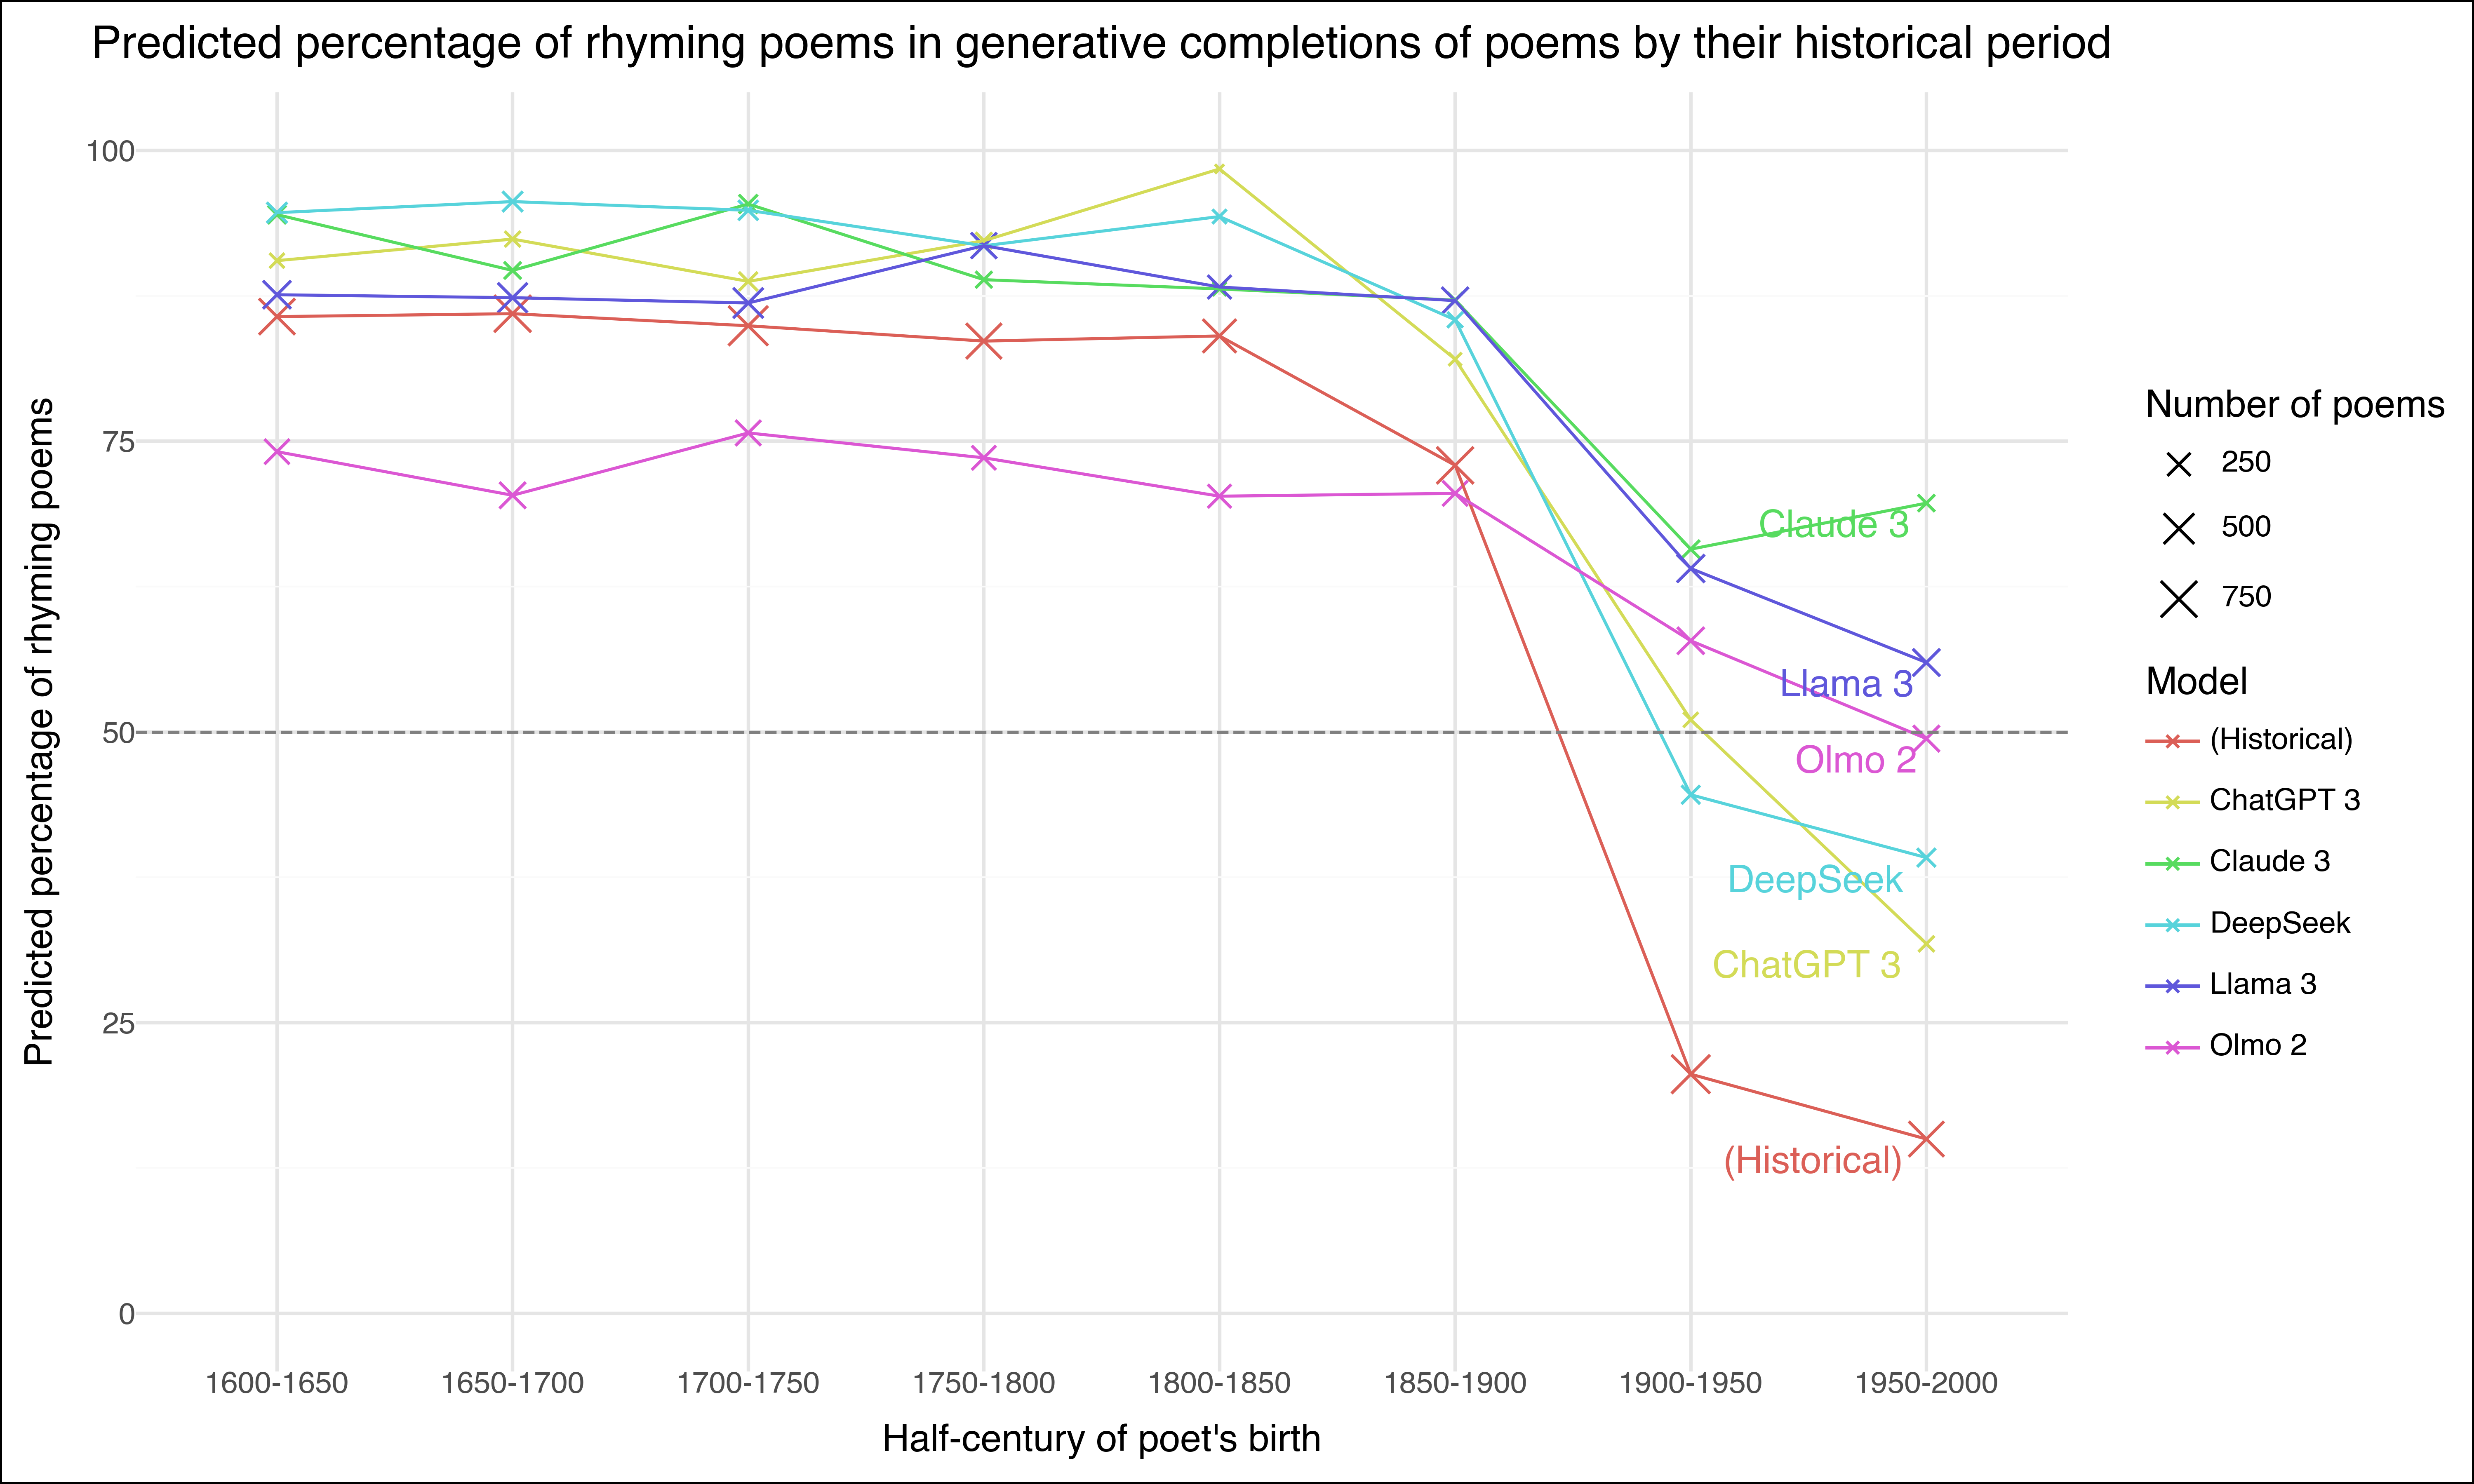

In [24]:
p9.options.figure_size = (10, 6)
figdf_avg = df.groupby(['period','model']).mean(numeric_only=True)#.reset_index()
figdf_avg['size'] = df.groupby(['period','model']).size()
figdf_avg = figdf_avg.reset_index()
models = [HIST] + [x for x in sorted(figdf_avg.model.unique()) if x!=HIST]
figdf_avg['model'] = pd.Categorical(figdf_avg.model, categories=models)
fig = p9.ggplot(figdf_avg, p9.aes(x='period', y='rhyme_pred_perc', color='model', group='model'))
fig += p9.geom_point(p9.aes(size='size'), shape='x')
fig += p9.geom_line()
fig += p9.theme_minimal()

fig += p9.geom_text(
    p9.aes(label='model'),
    data=figdf_avg[figdf_avg.period=='1950-2000'],
    adjust_text={'x':0.05, 'y':0.05, 'arrowprops': dict(arrowstyle='-', alpha=0)},
    
    show_legend=False,
)

# fig += p9.geom_text(p9.aes(label='model'), data=figdf_avg[figdf_avg.period=='1950-2000'], adjust_text={'x':0.1, 'y':0.1})
fig += p9.theme(panel_background=p9.element_rect(fill='white'), plot_background=p9.element_rect(fill='white'))
fig += p9.geom_hline(yintercept=50, color='gray', linetype='dashed')
fig += p9.scale_y_continuous(limits=(0,100))
fig += p9.labs(
    x='Half-century of poet\'s birth',
    y='Predicted percentage of rhyming poems',
    color='Model',
    size='Number of poems',
    title='Predicted percentage of rhyming poems in generative completions of poems by their historical period',

)
fig